In [18]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

notebook_dir = os.getcwd() 
src_path = os.path.abspath(os.path.join(notebook_dir, '../src'))
models_path = os.path.abspath(os.path.join(src_path, 'models'))
datasets_path = os.path.abspath(os.path.join(src_path, 'datasets'))
train_test = os.path.abspath(os.path.join(src_path, 'train&test'))
metrics_path = os.path.abspath(os.path.join(src_path, 'metrics'))
utils_path = os.path.abspath(os.path.join(src_path, 'utils'))


sys.path.append(src_path)
sys.path.append(models_path)
sys.path.append(datasets_path)
sys.path.append(train_test)
sys.path.append(metrics_path)
sys.path.append(utils_path)

from NN import Value, MLP
from preprocesing import processing, normalize
from cross_validation import cross_val
from train_validation import train_val_split
from mae import mae
from r2 import r2
from rmse import rmse
from logger import setup_logger

In [2]:
df = pd.read_csv('/home/facuvulcano/Machine-Learning/TP4/data/raw/toyota_dev.csv')
test_df = pd.read_csv('/home/facuvulcano/Machine-Learning/TP4/data/raw/toyota_test.csv')

In [3]:
df_path = processing(df)

Archivo guardado como: /home/facuvulcano/Machine-Learning/TP4/data/processed/dataset_procesado_20241014_203342.csv


In [12]:
test_df_path = processing(test_df)

AttributeError: Can only use .str accessor with string values!

In [5]:
processed_df = pd.read_csv(df_path)
processed_df = processed_df.drop(columns=['Nafta/GNC'])
processed_df = processed_df.drop(columns=['hibrido'])
processed_test_df = pd.read_csv(test_df_path)

#processed_df.to_csv('/home/facuvulcano/Machine-Learning/TP4/data/processed/dataset_procesado_20241014_183055.csv')
#processed_test_df.to_csv('/home/facuvulcano/Machine-Learning/TP4/data/processed/dataset_procesado_20241014_183058.csv')

In [6]:
X_test = processed_test_df.drop(columns=['Precio'])
y_test = processed_test_df['Precio']

In [7]:
X_train, X_val, y_train, y_val = train_val_split(processed_df, 'Precio')

In [8]:
features_to_normalize = ['Año','Kilómetros']
min_max_values = {feature : (X_train[feature].min(), X_train[feature].max()) for feature in features_to_normalize}


for feature in features_to_normalize:
    min_val, max_val = min_max_values[feature]
    X_train[feature] = normalize(X_train, feature, min_val, max_val, [0, 1])
    X_val[feature] = normalize(X_val, feature, min_val, max_val, [0, 1])
    X_test[feature] = normalize(X_test, feature, min_val, max_val, [0, 1])
    
y_min = y_train.min()
y_max = y_train.max()

y_train_norm = (y_train - y_min) / (y_max - y_min)
y_val_norm = (y_val - y_min) / (y_max - y_min)
y_test_norm = (y_test - y_min) / (y_max - y_min)

In [9]:
n = MLP(19, [10, 8, 4, 1])
print(f'Cantidad de parametros: {len(n.parameters())}')

Cantidad de parametros: 329


In [10]:
learning_rate = 1e-6
num_ephocs = 1000
batch_size = 32
train_losses = []
val_losses = []
X_train = np.array(X_train)
X_val = np.array(X_val)

In [11]:
logger = setup_logger('train_logger', 'logs/training.log')

for epoch in range(num_ephocs):
    epoch_loss = 0

    for i in range(len(X_train)):
        x = X_train[i]
        y_true = y_train_norm.iloc[i]
        y_pred = n(x)
        
        #calculo de la perdida (MSE)
        loss = (y_pred - y_true) ** 2
        epoch_loss += loss.data

        #Backpropagation
        loss.backward()

        #Acumular gradientes
        for p in n.parameters():
            p.data += -learning_rate * p.grad
        
        n.zero_grad()
    
    train_loss = epoch_loss / len(X_train)
    train_losses.append(train_loss)

    val_loss = 0
    y_val_pred = []
    for i in range(len(X_val)):
        x = X_val[i]
        y_true = y_val_norm.iloc[i]
        y_pred = n(x)
        y_val_pred.append(y_pred.data)
        val_loss += (y_pred.data - y_true) ** 2
    val_loss /= len(X_val)
    val_losses.append(val_loss)

    if epoch % 100 == 0:
        y_val_pred_array = np.array(y_val_pred).flatten()
        rmse_val = rmse(np.array(y_val_norm), y_val_pred_array)
        mae_val = mae(np.array(y_val_norm), y_val_pred_array)
        r2_val = r2(np.array(y_val_norm), y_val_pred_array)
        print(f'Epoca {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, RMSE={rmse_val:.4f}, MAE={mae_val:.4f}, R2={r2_val:.4f}')

    logger.info(f'Epoca {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')


Epoca 0: Train Loss=0.1153, Val Loss=0.1202, RMSE=0.3467, MAE=0.3217, R2=-6.1416
Epoca 100: Train Loss=0.0653, Val Loss=0.0686, RMSE=0.2619, MAE=0.2283, R2=-3.0753
Epoca 200: Train Loss=0.0406, Val Loss=0.0427, RMSE=0.2065, MAE=0.1679, R2=-1.5343
Epoca 300: Train Loss=0.0285, Val Loss=0.0297, RMSE=0.1724, MAE=0.1329, R2=-0.7655
Epoca 400: Train Loss=0.0226, Val Loss=0.0232, RMSE=0.1524, MAE=0.1153, R2=-0.3809
Epoca 500: Train Loss=0.0198, Val Loss=0.0200, RMSE=0.1413, MAE=0.1065, R2=-0.1871
Epoca 600: Train Loss=0.0184, Val Loss=0.0183, RMSE=0.1353, MAE=0.1021, R2=-0.0880
Epoca 700: Train Loss=0.0177, Val Loss=0.0174, RMSE=0.1321, MAE=0.0998, R2=-0.0361
Epoca 800: Train Loss=0.0174, Val Loss=0.0170, RMSE=0.1302, MAE=0.0987, R2=-0.0079
Epoca 900: Train Loss=0.0172, Val Loss=0.0167, RMSE=0.1292, MAE=0.0983, R2=0.0082


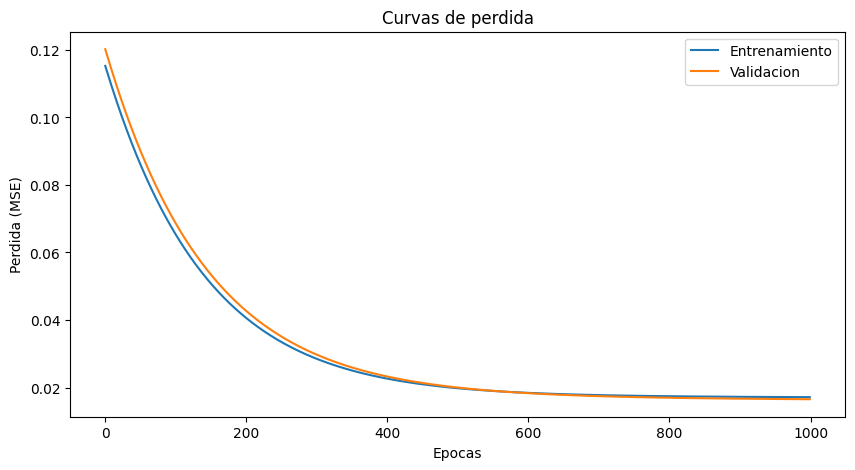

In [14]:
metrics_df = pd.DataFrame({
    'Epoch' : range(num_ephocs),
    'Train Loss' : train_losses,
    'Val Loss' : val_losses
})

metrics_df.to_csv('results/evaluation_metrics.csv', index=False)


plt.figure(figsize=(10, 5))
plt.plot(range(num_ephocs), train_losses, label='Entrenamiento')
plt.plot(range(num_ephocs), val_losses, label='Validacion')
plt.xlabel('Epocas')
plt.ylabel('Perdida (MSE)')
plt.title('Curvas de perdida')
plt.legend()
plt.savefig('results/loss_curves.png')
plt.show()

In [11]:
xs = np.array(X_train)
ys = (np.array(y_train) - np.array(y_train).min()) / (np.array(y_train).max() - np.array(y_train).min())

In [12]:
print(ys)

[0.27954936 0.67318782 0.34114534 ... 0.38581848 0.34006693 0.35201033]


In [13]:
# 1 ephoc con 5 iteraciones

EP = 5
ITER = 15

for _ in range(EP):
    for k in range(ITER):

        n.zero_grad()

        # forward pass    
        ypred = [n(x) for x in xs]
        for i in range(5):
            print(f'Prediccion: {ypred[i].data}, verdadero: {ys[i]}')
        loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

        # backward pass
        loss.backward()

        #update
        for p in n.parameters():
            p.data += -0.000001 * p.grad
        
        print(k, loss.data)

Prediccion: 0.022918299505087808, verdadero: 0.2795493617478293
Prediccion: 0.009552482440493046, verdadero: 0.6731878161959103
Prediccion: 0.0052671968467974065, verdadero: 0.34114534335882335
Prediccion: 0.02221003008218424, verdadero: 0.27875931850131924
Prediccion: -0.003847242955298793, verdadero: 0.13789199789610818
0 188.30809279440643
Prediccion: 0.024417458124357326, verdadero: 0.2795493617478293
Prediccion: 0.011027485106136308, verdadero: 0.6731878161959103
Prediccion: 0.006737498106586925, verdadero: 0.34114534335882335
Prediccion: 0.02370657536585729, verdadero: 0.27875931850131924
Prediccion: -0.0028366062959045684, verdadero: 0.13789199789610818
1 187.05371426654656
Prediccion: 0.02591236714886918, verdadero: 0.2795493617478293
Prediccion: 0.012498310609899402, verdadero: 0.6731878161959103
Prediccion: 0.008203641769939762, verdadero: 0.34114534335882335
Prediccion: 0.02519887811730258, verdadero: 0.27875931850131924
Prediccion: -0.0017848418848255428, verdadero: 0.13789

In [14]:
ypredicte = [(y * (np.array(y_train).max() - np.array(y_train).min())) + np.array(y_train).min() for y in ypred]

In [22]:
ypredicte

[Value(data=13038.725194248735, grad=0),
 Value(data=11709.764756330947, grad=0),
 Value(data=11299.040603606216, grad=0),
 Value(data=12959.995423644672, grad=0),
 Value(data=9582.279636277639, grad=0),
 Value(data=9478.653284129083, grad=0),
 Value(data=11058.650059067852, grad=0),
 Value(data=10459.274041490833, grad=0),
 Value(data=10212.434877787688, grad=0),
 Value(data=10629.515075405456, grad=0),
 Value(data=11583.599412817151, grad=0),
 Value(data=10511.466338825907, grad=0),
 Value(data=9839.19646802518, grad=0),
 Value(data=9456.420723371453, grad=0),
 Value(data=13002.87925937806, grad=0),
 Value(data=10628.858749282113, grad=0),
 Value(data=12782.272366278241, grad=0),
 Value(data=9812.689633217982, grad=0),
 Value(data=11584.593023600828, grad=0),
 Value(data=11358.640480933045, grad=0),
 Value(data=13037.681106286494, grad=0),
 Value(data=11547.530492582344, grad=0),
 Value(data=11580.568497474334, grad=0),
 Value(data=10400.868375425394, grad=0),
 Value(data=13004.95499

In [16]:
np.array(y_train)

array([27070.10526316, 62000.        , 32535.88516746, ...,
       36500.        , 32440.19138756, 33500.        ])

### 1.a) Implementacion de una red neuronal multicapa densa

**Objetivo:** Entrenar una red neuronal con 3 capas ocultas, con 10, 8 y 4 neuronas respectivamente, utilizando ReLU como funcion de activacion y unn learning rate 1e-8. Se evaluara el modelo en el conjunto de validacion utilizandometricas RMSE, MAE y R2, y se graficaran las curvas de error de entrenamiento y validacion.

In [1]:
%run /home/facuvulcano/Machine-Learning/TP4/src/train&test/train.py

Archivo guardado como: /home/facuvulcano/Machine-Learning/TP4/data/processed/dataset_procesado_20241015_005132.csv
Archivo guardado como: /home/facuvulcano/Machine-Learning/TP4/data/processed/dataset_procesado_20241015_005132.csv

Entrenando con lambda = 0
Cantidad de parametros: 329
Epoca 0: Train Loss=0.2494, Val Loss=0.2780, RMSE=29678.5210, MAE=27221.8652, R2=-5.3269
Epoca 100: Train Loss=0.1340, Val Loss=0.1524, RMSE=21972.5176, MAE=18812.6265, R2=-2.4679
Epoca 200: Train Loss=0.0881, Val Loss=0.1003, RMSE=17826.3912, MAE=14575.5486, R2=-1.2826
Epoca 300: Train Loss=0.0681, Val Loss=0.0765, RMSE=15564.1250, MAE=12333.3677, R2=-0.7400


KeyboardInterrupt: 

### 2. Implementacion de Learning Rate schedulers

**Objetivo:** Implementar diferentes estrategias de ajuste dinamico de la tasa de aprendizaje (Learning Rate schedulers) y comparar el rendimiento del modelo para cada una. Las variantesa explorar son:

a) Linear decay
b) Power law
c) Exponential decay

Se debe graficar la evolucion del error en funcion de las epocas para cada scheduler.

In [ ]:
scheduler_types = ['linear', 'power', 'exponential']
scheduler_params = {
    'linear' : {'final_lr' : 1e-7},
    'power' : {'power' : 0.5},
    'exponential' : {'decay_rate' : 0.01}
}

for scheduler_type in scheduler_types:
    print(f'\nEntrenando con scheduler: {scheduler_type}')

    %run /home/facuvulcano/Machine-Learning/TP4/src/train&test/train.py --scheduler_type {scheduler_type} --scheduler_param {scheduler_params[scheduler_type]}

    metrics_schedulers_df = pd.read_csv(f'results/evaluation_metrics_{scheduler_type}.csv')

    results_scheduler[scheduler_type] = metrics_schedulers_df
